In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor

In [60]:
df = pd.read_csv("C:/Users/chole/Desktop/Personal_medical_cost/insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [61]:
X = df.drop(columns=["charges"])
y = df.charges

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=X[["smoker"]])

In [108]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1070, 6) (268, 6) (1070,) (268,)


In [106]:
column_t = make_column_transformer(
    (OneHotEncoder(drop="if_binary"), ["sex", "region", "smoker"]),
    (StandardScaler(), ["age", "bmi", "children"]),
    remainder="passthrough"
)

In [127]:
names=[]
test_score =[]

models={'LR': LinearRegression(),
       'Lasso': Lasso(),
       'KNN': KNeighborsRegressor(),
       'Bayesian': BayesianRidge()

}

for name, model in models.items():

    pipe = Pipeline([
        ("preProc", column_t),
        ("model", model)
    ])
        
    fit_model = pipe.fit(X_train, y_train)
    pred_score = fit_model.score(X_test, y_test)

    test_score.append(pred_score)
    names.append(name)

dane = {
    "Names": names,
    "Score R^2": test_score
}

res = pd.DataFrame(dane)  
res


,Names,Score R^2
0,LR,0.788852
1,Lasso,0.788863
2,KNN,0.626426
3,Bayesian,0.788858


<AxesSubplot:xlabel='Names', ylabel='Score R^2'>

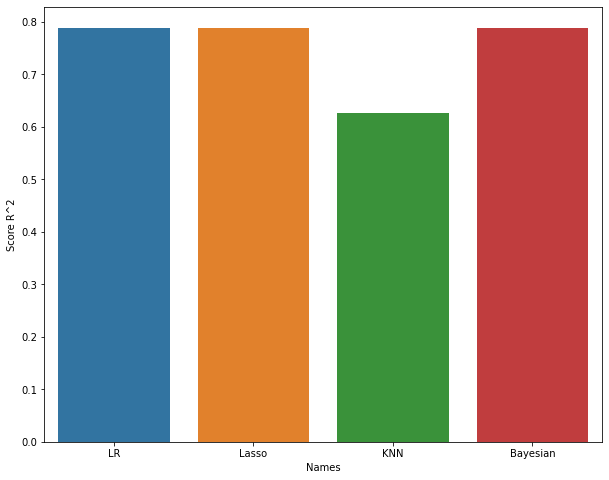

In [128]:
plt.rcParams['figure.figsize'] = [10, 8]  # for size
sns.barplot(x="Names", y = "Score R^2", data=res)

In [130]:
res.max()

Names           Lasso
Score R^2    0.788863
dtype: object